In [3]:
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
import os
import glob
import sys

# path to the upscaling utilities
sys.path.append("/home/josh/development/sourceFiles/MD-upscaling-utilities/") 

homeDir = os.path.abspath('.')

import subprocess as spr
import utilities as usu
from minimization import Minimizer
import time

import scipy as sci
from scipy import constants
import pickle

from minimization import *
from lammps_runner import *

from scipy.optimize import curve_fit

mpl.rcParams.update({'font.size': 12})
mpl.rcParams.update({'text.usetex': True})
mpl.rcParams.update({'font.family': 'serif'})

<script type="text/x-mathjax-config">
MathJax.Hub.Config({
  TeX: { equationNumbers: { autoNumber: "AMS" } }
});
</script>

In this notebook, we'll optimize the (m)ultybody DPD force kernel (*a priori* and *a posteriori*) with pressure computed from molecular dynamics simulations as a target for optimization.

The pairwise force, $\mathbf{F}_{ij}$, associated with the DPD class of models is a sum of three distinct forces,
\begin{equation}
    \mathbf{F}_{ij}=\mathbf{F}_{ij}^{C}+\mathbf{F}_{ij}^{D}+\mathbf{F}_{ij}^{R}, 
\end{equation}
where $\mathbf{F}_{ij}^{C}$, $\mathbf{F}_{ij}^{D}$, $\mathbf{F}_{ij}^{R}$ are the conservative, dissipative, and random components, respectively, of $\mathbf{F}_{ij}$. 
Because pressure is governed by the conservative force we'll only need to consider the parameters which $\mathbf{F}_{ij}^{C}$ depends on.
For mDPD, the conservative force is a combination of a long-range attractive force and a short-range repulsive force, and is written as

\begin{equation}
    \mathbf{F}_{ij}^{C}
    =
    \underbrace{A_{ij}\omega^{c}\left(r_{ij}\right)\mathbf{e}_{ij}}
    _{\mathrm{{long\,range\,attractive}}}
    +
    \underbrace{B_{ij}\left(\bar{\rho}_{i}+\bar{\rho}_{j}\right)\omega^{d}(r_{ij})\mathbf{e}_{ij}}
    _{\mathrm{short\,range\,repulsive}},
    \label{eq:DPD conservative force}
\end{equation}
where $r_{ij}=||\mathbf{r}_{ij}||$, $\mathbf{r}_{ij}=\mathbf{r}_{i}-\mathbf{r}_{j}$, $\mathbf{e}_{ij}=\mathbf{r}_{ij}/r_{ij}$. Parameters $A_{ij}<0$ and $B_{ij}>0$ are material-dependent parameters and must be calibrated prior to DPD calculations. 

Variables $r_c$ and $r_d$ are, respectively, the attractive and repulsive cutoff radii, and are determined heuristically as is done in [Warren 2003], or through an optimization procedure.
Parameters $A<0$ and $B>0$ are material-dependent parameters and must be calibrated prior to DPD calculations.
The reader is referred to [Warren 2003] for the specifics of equation for $\mathbf{F}_{ij}^{C}$ as well as the details of dissipative and random components of equation for $\mathbf{F}_{ij}$.

In this work, pressure is chosen as the target property used for optimizing conservative force parameters $A$ and $B$. 
The pressure of a system of $N_p$ particles which interact in a pairwise manner within a volume $V$ is expressed as 
\begin{align}
    P
    &=
    \underbrace{\frac{N_p k_B T}{V}}
    _{P_\mathrm{ideal}}
    +
    \frac{1}{6V}\sum_{j=1}^{N_p}\sum_{i\neq j}^{N_p}\mathbf{r}_{ij}\cdot\mathbf{f}_{ij},
    \label{eq:system pressure}
    \\
    &=
    \frac{1}{N_p}\sum_{i}^{N_p} P_i,
\end{align}
where  $\mathbf{f}_{ij}$ is the force acting on particle $i$ due to particle $j$ and the per-particle contribution is
\begin{equation}
    P_i 
    =
    P_\mathrm{ideal}
    +
    \frac{N_p}{6V}
    \sum_{i\neq j}^{N_p}\mathbf{r}_{ij}\cdot\mathbf{f}_{ij}.
    \label{eq:per-particle pressure}
\end{equation}


Go to a directory where having many (potentially hundreds) of files written is acceptible 

In [12]:
os.chdir("/home/josh/runs/DPD/heptane-303K/")

In [5]:

domainLen = 112.4

# Pascals per atmosphere
paPerAtm = 1.01325e5

# femtoseconds per second
fsPerS = 1e15

angstromPerMeter = 1e10

T_MD = 303
kbT = 1

rCutDPD = 11.24 # angstroms

# change these directories to point to the MD data downloaded from Google Drive

In [14]:
dataDirs = [\
            "/home/josh/runs/MD-run/case-1/", \
            "/home/josh/runs/MD-run/case-2/", \
            "/home/josh/runs/MD-run/case-3/", \
            "/home/josh/runs/MD-run/case-4/", \
            "/home/josh/runs/MD-run/case-5/", \
            "/home/josh/runs/MD-run/case-6/",
           ]



# *a priori* optimizatation

The procedure for *a priori* optimization is summarized as follows:

1. Obtain per-molecule pressure contributions, $P^{MD}_i$, from molecular dynamics computations
2. Set DPD particle positions at molecular centers of mass.
3. Compute per-particle pressure contributions, $P^{DPD}_i$, by substituting equation for the DPD conservative force into the equation for per-particle pressure.
4. Minimize an objective function, $S(A,B)$, defined below.

Two approaches to *a priori* optimization are considered here. 

## approach 1
The first approach is optimization based on obtaining parameters $A$ and $B$ for each individual dataset, $k$, which uses the following objective function
\begin{equation}
    S_k^\textit{a priori}(A,B;\rho_k) 
    = 
    \sum_{i=1}^{N_{M,k}}\sum_{j=1}^{N_t}\left[ P^{DPD}_i(A,B;t_j, \rho_k)  - P^{MD}_i(t_j, \rho_k)\right]^2
    \label{eq:prior objective fcn individual}
\end{equation}
where 
- $N_{M,k}$ is the number of molecules for dataset $k$, 
- $N_t$ is the number of time snapshots considered, 
- $t_j$ is the time corresponding to time snapshot $j$, 
- $P^{DPD}_i(A,B;t_j, \rho_k)$ is the pressure contribution from molecule $i$ for specified $A$, $B$ at time snapshot $j$ computed from the DPD conservative force, and  
- $P^{MD}_i(t_j, \rho_k)$ is the pressure contribution from molecule $i$ at time snapshot $j$ from molecular dynamics dataset $k$.

For the mDPD conservative force, pressure can be decomposed into $P_\mathrm{ideal}$, $g^A_i$, and $g^B_i$ by substituting the attractive and repulsive components individually into the equation for $P_i$ given above 
\begin{equation}
    P^{DPD}_i
    =
    P_\mathrm{ideal}
    +
    Ag^A_i
    +
    Bg^B_i
\end{equation}

where $g^A_i$ and $g^B_i$ are the attractive and repusive contributions, respectfully, of the mDPD conservative force to the per-particle pressure.

We can constrain our optimization problem by reduce the number of unknowns by take advantage of $P^{DPD}_i = P_\mathrm{ideal} + Ag^A_i + Bg^B_i$ in the following manner:
\begin{align}
    \langle P^{MD}_i \rangle 
    &= \langle P^{DPD}_i \rangle \\
    &= P_\mathrm{ideal} + A\langle g^A_i \rangle + B\langle g^B_i \rangle \\
    \implies 
    A\langle g^A_i \rangle + B\langle g^B_i \rangle 
    &= P^{MD}_i - P_\mathrm{ideal} \\
    \implies
    B 
    &= 
    \frac{1}{\langle g^B_i \rangle}
    \left( \langle P^{MD}_i \rangle - P_\mathrm{ideal} - A\langle g^A_i \rangle\right),
\end{align}
where $\langle \cdot \rangle$ indicates a mean over both paricles and time observations, which guaruntees that $\langle P^{DPD}_i \rangle = \langle P^{MD}_i \rangle$. This only works for optimization for a single dataset, $k$

## approach 2
The second optimization approach utilizes multiple datasets spanning multiple molar densities, $\rho_k$, and uses an objective function expressed as
\begin{equation}
    S^\textit{a priori}(A,B) 
    = 
    \sum_{k}^{N_{M,k}}S_k^\textit{a priori}(A,B;\rho_k). 
    \label{eq:prior objective fcn combined}
\end{equation}

The following function computes $S_k^\textit{a priori}(A,B)$ for individual values of $k$ (**approach 1**) or $S^\textit{a priori}(A,B)$ (**approach 2**) defined above. For **approach 2**, values of $g^A_i(t_j, \rho_k)$, $g^B_i(t_j, \rho_k)$, and $P^{MD}_i(t_j, \rho_k)$ are concatenated into a single 1-dimensional array

In [16]:
# objective function for determining mDPD attractive and repulsive conservative force parameters
def a_priori_objective_func(AandB_, gA_, gB_, pEx_MD, pow_):

    # P_ex
    A_ = AandB_[0]
    B_ = AandB_[1]
    
    # compute excess pressure according to the mDPD model (P_DPD - P_ideal)
    pEx_DPD = A_*gA_ + B_*gB_
    return np.sum(np.abs(pEx_DPD - pEx_MD)**pow_)



/home/josh/runs/MD-run/case-1/
MD pressure (MPa): 3.4
n moleules: 5843
[A,B]: [-10.63224839   5.26349636]
A/B  : -2.019997291294072
relative error: -2.4424906541753444e-15
-----------------------------
/home/josh/runs/MD-run/case-2/
MD pressure (MPa): 11.8
n moleules: 5920
[A,B]: [-10.4139129   5.5181132]
A/B  : -1.887223500961182
relative error: -3.774758283725532e-15
-----------------------------
/home/josh/runs/MD-run/case-3/
MD pressure (MPa): 22.37
n moleules: 6000
[A,B]: [-8.88062342  5.17199777]
A/B  : -1.7170586335662312
relative error: 3.219646771412954e-15
-----------------------------
/home/josh/runs/MD-run/case-4/
MD pressure (MPa): 36.67
n moleules: 6100
[A,B]: [-7.74585783  5.03608986]
A/B  : -1.5380698213070958
relative error: 2.220446049250313e-15
-----------------------------
/home/josh/runs/MD-run/case-5/
MD pressure (MPa): 52.83
n moleules: 6200
[A,B]: [-6.53538779  5.06409453]
A/B  : -1.2905343191410639
relative error: 4.3298697960381105e-15
------------------------

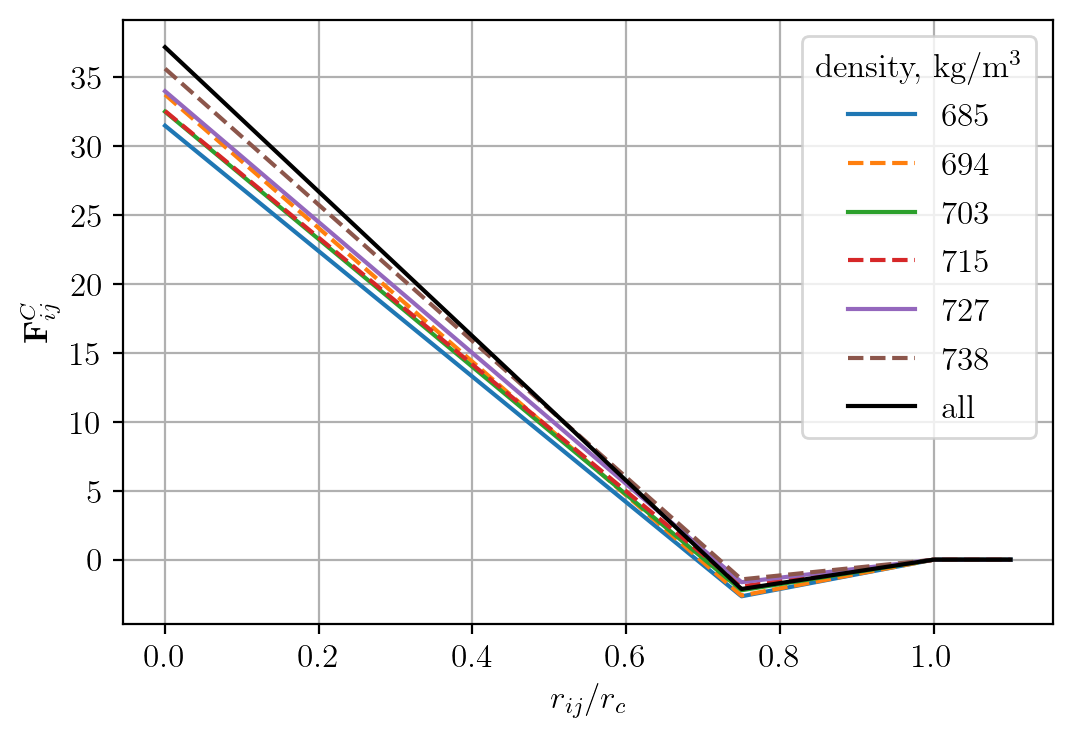

In [17]:
fig = plt.figure()
fig.set_dpi(200)

exponent = 1

# These will be arrays with 
gA_All              = np.array([])
gB_All              = np.array([])
pExcessReducedMDAll = np.array([])
linestyles = ['-','--']

meanDensReduced = 0

# molecular weight of heptane in kg/mol
mw =100.21/1000

meanMDPressures = []
densities = []
nMolecules = []

AVals = []
BVals = []

referenceDensReduced = 4

for i,dataDir in enumerate(dataDirs):
    print(dataDir)
    
    #load some stuff
    times    = np.load(os.path.join(dataDir, 'timesDPD.npy'           ))
    pTotalMD = np.load(os.path.join(dataDir, 'pressure.npy'           ))
    gA       = np.load(os.path.join(dataDir, 'pressDPD_attractive.npy'))
    gB       = np.load(os.path.join(dataDir, 'pressDPD_repulsive.npy'  ))
    densReduced = pTotalMD.shape[1]/(domainLen/rCutDPD)**3
    
    meanDensReduced += densReduced/len(dataDirs)
    
    densities.append( pTotalMD.shape[1]/(domainLen/angstromPerMeter)**3/constants.Avogadro*mw )
    
    meanMDPressures.append(pTotalMD.mean())
    
    nMolecules.append(pTotalMD.shape[1])
    meanPress = round(meanMDPressures[-1]*1e-6, 2) #in MPa
    print('MD pressure (MPa):', meanPress)
    print('n moleules:', nMolecules[-1])

    pExcessReducedMD = pTotalMD[times]*usu.get_pressure_reduction_factor(rCutDPD,T_MD) - kbT*densReduced
      
    gA_All              = np.concatenate([gA_All,              gA              .flatten()])
    gB_All              = np.concatenate([gB_All,              gB              .flatten()])
    pExcessReducedMDAll = np.concatenate([pExcessReducedMDAll, pExcessReducedMD.flatten()])

    pTol = abs(pExcessReducedMD.mean())*0.0
    lb = [pExcessReducedMD.mean()-pTol]
    ub = [pExcessReducedMD.mean()+pTol]

    # this constrataint guaruntees  
    # mean(P^MD_i) - P_ideal = mean(P^DPD_i) - P_ideal 
    #                        = A*mean(g^A_i) + B*mean(g^B_i)
    constraintMat = np.array([
                             [gA.mean(), gB.mean()],
                             ])
    constraint = sci.optimize.LinearConstraint(constraintMat, 
                                                lb=lb, 
                                                ub=ub)


    # perform a priori optimization using approach 1 for density observation i
    opAPriori = sci.optimize.minimize(a_priori_objective_func,
                               x0 = [-1, 1],     # this is an initial guess  for [A,B]
                               args=(gA.flatten(), 
                                     gB.flatten(), 
                                     pExcessReducedMD.flatten(),
                                     exponent),
                               # comment the line below to remove the constraint
                               constraints=constraint
    #                                      bounds=[(-100,-1),(0,100)]
                              )
    
    AVals.append(opAPriori.x[0])
    BVals.append(opAPriori.x[1])
    print('[A,B]:',opAPriori.x)
    print('A/B  :', opAPriori.x[0]/opAPriori.x[1])
    computedExcessPress = usu.p_excess_dpd_from_components([gA, gB], *opAPriori.x)
    relError = 1 - computedExcessPress.mean()/pExcessReducedMD.mean()
    print('relative error:', relError)
    print('-----------------------------')

    rSep = np.linspace(0,1.1, 501)
    linestyle = linestyles[i%len(linestyles)]
    plt.plot(rSep, usu.mDPD_force(opAPriori.x[0], opAPriori.x[1], referenceDensReduced, 1, 0.75, rSep), label=str(round(densities[-1])), linestyle=linestyle)
    #     if key is np.inf: continue
    #     _=plt.hist((densReduced*kbT+computedExcessPress.flatten()) \
    #                /get_pressure_reduction_factor(rCutDPD,T_MD)*1e-6,
    #                100, histtype='step', 
    #                fill=False, linewidth=1.4, density=True, label=str(round(key,2)), linestyle=linestyle)

    
# perform a priori optimization using approach 2    
opAPriori = sci.optimize.minimize(a_priori_objective_func,
                           x0 = [-1, 1],
                           args=(gA_All, 
                                 gB_All, 
                                 pExcessReducedMDAll,
                                 exponent),
                          )

A_allDens = opAPriori.x[0]
B_allDens = opAPriori.x[1]


print('[A,B]:',opAPriori.x)
# computedExcessPress = usu.p_excess_dpd_from_components([gA, gB], *opAPriori.x)
# relError = 1 - computedExcessPress.mean()/pExcessReducedMD.mean()
# print('relative error:', relError)
# print('-----------------------------')

# compute presures pedicted from parameters optimized with all data

aPrioriPressures = []
for i,dataDir in enumerate(dataDirs):
    times    = np.load(os.path.join(dataDir, 'timesDPD.npy'           ))
    pTotalMD = np.load(os.path.join(dataDir, 'pressure.npy'           ))[times]
    gA       = np.load(os.path.join(dataDir, 'pressDPD_attractive.npy'))
    gB       = np.load(os.path.join(dataDir, 'pressDPD_repulsive.npy' ))
    densReduced = pTotalMD.shape[1]/(domainLen/rCutDPD)**3
    
    computedExcessPress = usu.p_excess_dpd_from_components([gA, gB], *opAPriori.x)
    aPrioriPressures.append(computedExcessPress.mean() + densReduced*kbT)
                     
    
aPrioriPressures = np.array(aPrioriPressures)/usu.get_pressure_reduction_factor(rCutDPD,T_MD)
meanMDPressures = np.array(meanMDPressures)

rSep = np.linspace(0,1.1, 501)
plt.plot(rSep, usu.mDPD_force(opAPriori.x[0], opAPriori.x[1],referenceDensReduced, 1, 0.75, rSep), label='all', color='k')

plt.grid('on')
plt.legend(title='density, kg/m$^3$')
plt.xlabel(r'$r_{ij}/r_c$')
plt.ylabel(r'$\mathbf{F}^C_{ij}$')

del gA_All
del gB_All
del pExcessReducedMDAll

In [18]:
meanMDPressures*1e-6 # pressures in MPa

array([ 3.39587228, 11.80188149, 22.37381015, 36.66561813, 52.82676148,
       71.73331763])

# *a posteriori optimization*
The *a posteriori* optimization procedure described here utilizes pressures computed directly from DPD simulations where the following objective function is used
\begin{equation}
    S^\textit{a posteriori}(A,B) 
    = 
    \sum_{k}
    \left[ 
    \left\langle P^{DPD}_i(A,B;\rho_k) \right\rangle  - \left\langle P^{MD}_i(\rho_k) \right\rangle 
    \right]^2
    \label{eq:posterior objective fcn}
\end{equation}
where $\langle \cdot \rangle$ denotes a mean over both time and number of particles.

- Obtain initial guesses for parameters $A$ and $B$ using the *a priori* optimization procedure outlined above.
- Minimize the objective function, $S^\textit{a posteriori}(A,B)$.
It is crucial to note that minimization of $S^\textit{a posteriori}(A,B)$ is necessarily done in an \emph{iterative} manner, and that each iteration requires multiple DPD simulations.


The function `posterior_dpd_pressure` runs a series of mDPD simulations and computes $S^\textit{a posteriori}(A,B)$ given [A,B] = `args_` as well as other parameters needed to run an mDPD simulation with LAMMPS. 

In [19]:
def posterior_dpd_pressure(args_, 
                           info_,
                           mpiRanks_,
                           plot=False):
    A_ = args_[0]
    B_ = args_[1]   
    
    # set gamma based on the value of A.
    # this could be set in a different way, but this ensures that
    # the random force is proportonal to the attractive component of
    # the mDPD conservative force
    gamma_ = abs(A_*info_['gammaARatio'])
    
    dumpFile_ = lammpsRun.inputParams['dumpFileName']
    if os.path.exists(dumpFile_):
        os.remove(dumpFile_)
    
    lammpsRun.inputParams['A'] = A_
    lammpsRun.inputParams['B'] = B_
    lammpsRun.inputParams['gamma'] = gamma_
    print('A:', lammpsRun.inputParams['A'])
    print('B:', lammpsRun.inputParams['B'])
    print('gamma:', lammpsRun.inputParams['gamma'])
    
    kbT_ = info_['kbT']
    numEval_ = len(info_['nParticles'])
    assert(len(info_['target reduced pressure']) == numEval_)
    
    error_ = [];
    
    for i_eval in range(numEval_):
        np_ = info_['nParticles'][i_eval]
        lammpsRun.inputParams['nParticles'] = np_
        
        print('evaluation', i_eval+1,'/', numEval_, '-------------')
        print('nParticles:', lammpsRun.inputParams['nParticles'])
        
        filePrefix_ = 'np='+str(np_)+'_A='+str(float(A_))+"_B="+str(float(B_))

        locInFile_ = filePrefix_+'.in'
        lammpsRun.create_input_file(locInFile_)
        rightNow_ = time.time()
        lp_ = lammpsRun.run_lammps(mpiRanks_,locInFile_)
    #     print(os.waitpid(lp_.pid,0))
    #     time.sleep(5)

        output_ = lp_.communicate()
        print('error messages (if any):')
        for line in output_[1].decode('ascii').split('\n'):
            print(line)

        print('LAMMPS computation took', time.time()-rightNow_,'seconds')
        print('---------------')

        # enable restarting:
    #     dotIdx = dumpFile_.rfind('.')
    #     dumpFile_[:dotIdx]
    #     lammpsRun.inputParams['restart'] = dumpFile_[:dotIdx]+'.restart.*'


        dpdThermo_ = usu.parse_lammps_log(output_[0],ignoreFirstOutput_=True)
        pickle.dump(dpdThermo_, open(filePrefix_+'.p', 'wb'))
        
        idealPressure_  = kbT_*np_/(lammpsRun.inputParams['boxLength'])**3
        targetPressure_ = info_['target reduced pressure'][i_eval]

        posteriorDPDPressure_ = np.mean(dpdThermo_['Press'])
        print('DPD reduced total pressure :', posteriorDPDPressure_)
        print('DPD reduced excess pressure:', posteriorDPDPressure_-idealPressure_)
        
        # compute the error 
        pressTotError_ = posteriorDPDPressure_ - targetPressure_
        print('absolute pressure error:', pressTotError_)
        print('relative excess pressure error:', pressTotError_/(posteriorDPDPressure_-idealPressure_))
        if plot:
            plt.plot(dpdThermo_['Elapsed'],dpdThermo_['Press'])
        
        # add newly-computed error to the list -- the 2-norm of this list will be the final result
        error_.append(pressTotError_)

    print('errors:', error_)
    return np.linalg.norm(error_,2)**2

In [7]:

templateDir = 'template.in'

inParams = {'dt':0.01,
            'boxLength': 10,
            # the following parameters will be set when executing posterior_dpd_pressure,
            # but they are required for LAMMPS_runner, so they are set to None here
            'nParticles':None,
            'A'         :None,
            'B'         :None,
            'gamma'     :None,
            # ------------------------------------------
            'randSeed':574856,
            'rd':0.75,
            'preRunSteps':50000,
            'runSteps':100000,
            'dumpFrequency':10000,
            'thermoFrequency':50,
            'restartFrequency':100000,
            'dumpFileName':"delMe.xyz"}

lammpsBin = "/home/josh/development/sourceFiles/lammps-inl/src/lmp_mpi"

lammpsRun = LAMMPS_runner(lammpsBin,
                          inParams,
                          templateDir)
lammpsRun.iteration = 0
gammaARatio = -0.125
reduceFactor = usu.get_pressure_reduction_factor(rCutDPD, T_MD)

idxs = [0,3,5]
npList          = [nMolecules[i] for i in idxs]
targetPressList = [meanMDPressures[i]*reduceFactor for i in idxs]

print('n particles : reduced pressure')
for nprt,press in zip(npList,targetPressList):
    print(nprt,':', press)

infoDict = {\
            'target reduced pressure': targetPressList, \
            'nParticles'             : npList, \
            'kbT'                    :kbT, \
            'gammaARatio':gammaARatio, \
           }

mpiRanks = 16


n particles : reduced pressure
5843 : 1.1527214403251345
6100 : 12.446064102723637
6300 : 24.3497182139234


# Perform the optimization. Optimal values should be [A,B] = [-35.85,  24.24]

In [ ]:
# values of mDPD parameters obtained from a priori optimization over all densities
# considered
A_init = -8.514924710173986 
B_init = 5.710544604581872

bounds = Bounds(minVals=[-np.inf, 0], maxVals=[0, np.inf])
otherArgs={
    'stepRange':[0.1,np.inf], # step size, min and max 
    'sigma':2, # factor by which the step for the line search is devided
    'bounds':bounds, # bounds for parameters
    'betaForm': 'FR', # determines what conjugate gradient formula is used options are 'FR' and 'WYL'
    'verbose':True # verbose
}

guess = np.array([A_init,B_init])

minimizer1 = Minimizer(posterior_dpd_pressure,funcParams=[infoDict,mpiRanks])
result1 = minimizer1.minimize(guess,
                            dxMax=[0.05, 0.05],
                            gradTol=1e-3,
                            dxTol=0.1, 
                            maxNewtonIter=25, 
                            scheme='cg', 
                            kwargs=otherArgs)

# Optimal DPD parameters [A,B]

In [61]:
result1

array([-35.85021617,  24.24401016])

# Number of function evaluations

In [62]:
minimizer1.nEvals


48

# Some plots of solver behavior

Text(0, 0.5, 'B')

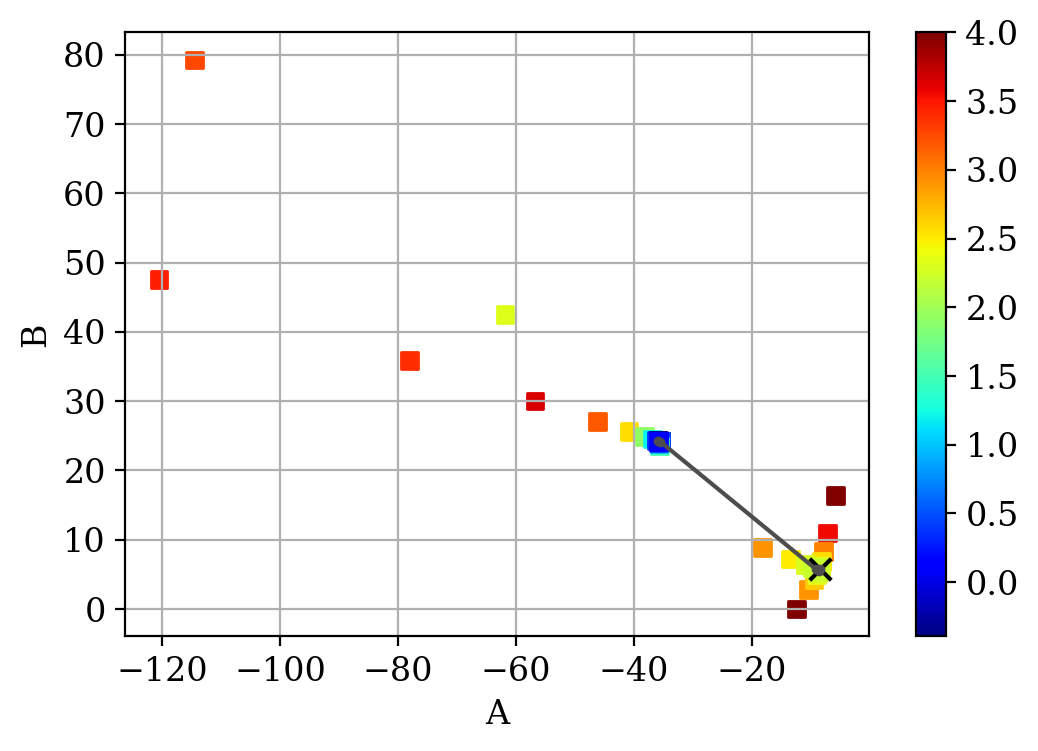

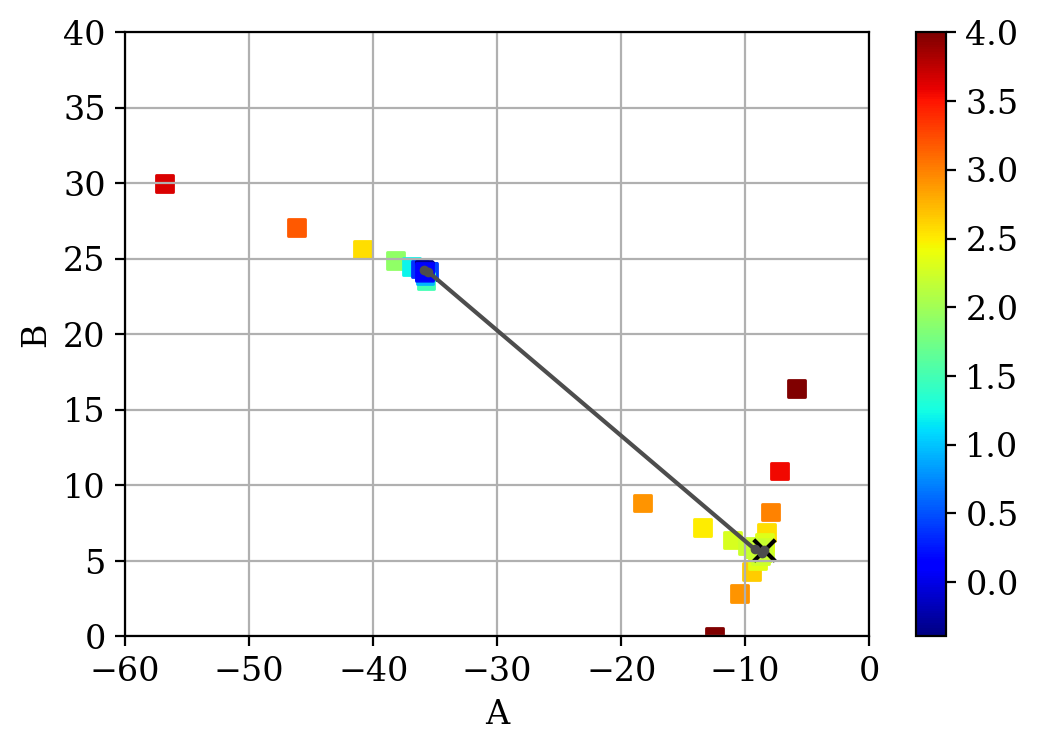

In [66]:
mpl.rcParams.update({'text.usetex': False})
guessList = np.array([pv[0] for pv in minimizer1.paramVals])
fv= []
a = []
b = []
for i,pv in enumerate(minimizer1.paramVals):
    fv+=minimizer1.funcVals[i]
    a += [pvi[0] for pvi in pv]
    b += [pvi[1] for pvi in pv]
    
#     pvArray = np.array(pv)
#     plt.scatter(pvArray[:,0],pvArray[:,1], c=minimizer.funcVals[i])

fv = np.array(fv)
fv = np.clip(np.log10(fv),-10,4)
pvArray = np.array(pv)
fig = plt.figure()
fig.set_dpi(200)
plt.scatter(a,b, c=fv, marker='s', cmap=plt.cm.jet)
plt.colorbar()
plt.grid()

plt.scatter(guessList[0,0], guessList[0,1], marker='x', s=60, color='k')
plt.plot(guessList[:,0], guessList[:,1], marker='.', markersize=5, color=[0.3 for _ in range(3)])


plt.xlabel('A')
plt.ylabel('B')

fig = plt.figure()
fig.set_dpi(200)
plt.scatter(a,b, c=fv, marker='s', cmap=plt.cm.jet)
plt.colorbar()
plt.grid()

plt.scatter(guessList[0,0], guessList[0,1], marker='x', s=60, color='k')
plt.plot(guessList[:,0], guessList[:,1], marker='.', markersize=5, color=[0.3 for _ in range(3)])
plt.xlim(-60, 0)
plt.ylim(0, 40)

plt.xlabel('A')
plt.ylabel('B')

0